## Project: Zero-Shot Classification of Health Questions using BART

This project applies Hugging Face’s `facebook/bart-large-mnli` transformer to classify COVID-related health questions into broader categories using **zero-shot learning**. No task-specific training was performed.

The model processes real-world health-related text and predicts one of six broad categories. This serves as a proof-of-concept for using LLMs in medical text triage or classification pipelines.

**Tools:**  
Python, Hugging Face Transformers, Matplotlib  

In [ ]:
# # Synthetic clinical messages
# examples = [
#     "Can I get a refill for my blood pressure meds?",
#     "I need to schedule my annual physical.",
#     "My headache is getting worse since yesterday.",
#     "Please update my insurance details in the system.",
#     "Is it okay to take this medication with food?",
#     "I missed my appointment and need to reschedule.",
#     "How much should I take if I missed a dose?",
#     "Can someone call me to confirm my follow-up?",
#     "I think I'm having side effects from the new pills.",
#     "I uploaded my new insurance card to MyChart.",
#     "When will the test results be available?",
#     "I’ve been feeling dizzy and nauseous for two days.",
#     "Can I talk to a nurse about vaccine eligibility?",
#     "I was charged incorrectly for my last visit.",
#     "Do I need a referral to see a dermatologist?",
#     "Please cancel my appointment for next Tuesday.",
#     "Can I take ibuprofen with my blood thinner?",
#     "My cough is worse at night and I have a mild fever.",
#     "How do I get access to my medical records?",
#     "What time should I arrive for my MRI appointment?"
# ]

# # Classification categories
# candidate_labels = ["medication", "appointment", "symptoms", "billing", "administrative", "other"]

## 📂 Dataset

We use the COVID-Q dataset (Wei et al., 2020), which contains over 1,600 de-identified health-related questions submitted during the COVID-19 pandemic.

Each question is labeled with a fine-grained category (e.g., "Symptoms - Fever", "Testing - PCR"), which we group into 6 broader categories:

- **Symptoms**
- **Testing**
- **Treatment**
- **Social Impact**
- **Information**
- **Other**

In [ ]:
import pandas as pd

url = "https://raw.githubusercontent.com/JerryWei03/COVID-Q/master/final_master_dataset.csv"
df = pd.read_csv(url)

df.head()

,Category,Question ID,Question,Source,Answers
0,Speculation - Pandemic Duration,42,will covid end soon,Google Search,"may 1st, i think, is completely unrealistic, s..."
1,Speculation - Pandemic Duration,42,will covid end,Yahoo Search,"may 1st, i think, is completely unrealistic, s..."
2,Speculation - Pandemic Duration,42,when covid will be over,Google Search,"may 1st, i think, is completely unrealistic, s..."
3,Speculation - Pandemic Duration,42,when covid lockdown ends,Google Search,"may 1st, i think, is completely unrealistic, s..."
4,Speculation - Pandemic Duration,42,will covid go away,Google Search,"may 1st, i think, is completely unrealistic, s..."


In [ ]:
df = df[df["Category"].notnull() & df["Question"].notnull()].copy()
# Create broad categories by extracting first word before ' - '
df["Broad_Category"] = df["Category"].str.split(" - ").str[0]
df = df[df["Broad_Category"].notnull()].copy()

In [ ]:
# Map to Broader Categories
label_map = {
    "Symptoms": ["Symptoms", "Having COVID"],
    "Testing": ["Testing", "Reporting"],
    "Treatment": ["Treatment", "Prevention"],
    "Social Impact": ["Societal Effects", "Economic Effects", "Societal Response", "Individual Response"],
    "Information": ["Nomenclature", "Origin", "Speculation", "Comparison"],
    "Other": ["Other"]
}

flat_map = {}
for broad, fine_list in label_map.items():
    for fine in fine_list:
        flat_map[fine] = broad

df["Grouped_Category"] = df["Broad_Category"].map(flat_map)
df = df[df["Grouped_Category"].notnull()].copy()

In [ ]:
# Prepare Data
texts = df["Question"].astype(str).tolist()
true_labels = df["Grouped_Category"].tolist()
candidate_labels = sorted(set(true_labels))

## ⚙️ Model

We use Hugging Face’s `facebook/bart-large-mnli` in a zero-shot classification setting. This model was fine-tuned on the MNLI dataset to perform natural language inference (NLI) and can be adapted to label classification tasks without additional training.

Candidate labels are provided as plain text, and the model scores how well each label fits the input question.

In [ ]:
# Load Zero-Shot Model
!pip install transformers -q
from transformers import pipeline

classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=0)

Device set to use cuda:0


In [ ]:
# Run Predictions
results = classifier(texts, candidate_labels, batch_size=8)
predicted_labels = [r["labels"][0] for r in results]

In [ ]:
# Evaluate Accuracy
correct = sum(p == t for p, t in zip(predicted_labels, true_labels))
total = len(true_labels)
accuracy = correct / total
print(f"✅ Model Accuracy on {total} examples: {correct}/{total} = {accuracy:.2%}")

✅ Model Accuracy on 1013 examples: 325/1013 = 32.08%


In [ ]:
# Show Sample Misclassifications
print("\n🔍 Misclassified Examples:")
for i, (text, pred, true) in enumerate(zip(texts, predicted_labels, true_labels)):
    if pred != true and i < 10:
        print(f"\n{i+1}. 📩 Text: {text}")
        print(f"   ❌ Predicted: {pred}")
        print(f"   ✅ True:      {true}")


🔍 Misclassified Examples:

1. 📩 Text: will covid end soon
   ❌ Predicted: Symptoms
   ✅ True:      Information

5. 📩 Text: will covid go away
   ❌ Predicted: Symptoms
   ✅ True:      Information

7. 📩 Text: will covid ever go away
   ❌ Predicted: Symptoms
   ✅ True:      Information

8. 📩 Text: when covid over
   ❌ Predicted: Other
   ✅ True:      Information

9. 📩 Text: will covid ever end
   ❌ Predicted: Other
   ✅ True:      Information


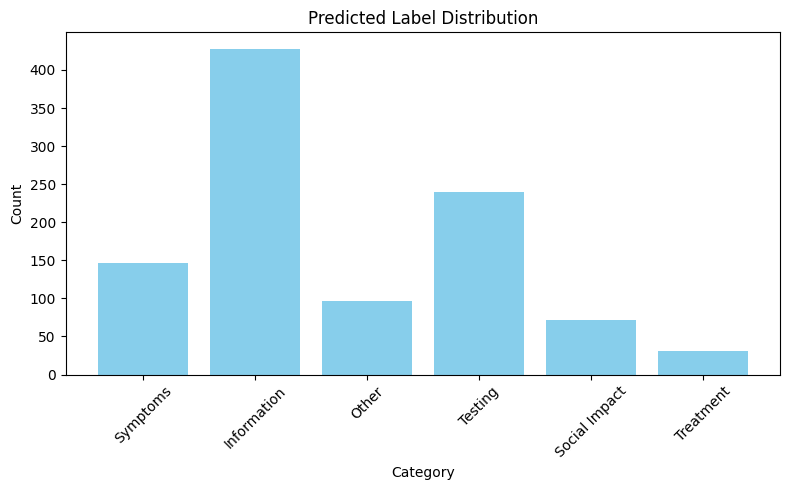

In [ ]:
# Visualize Label Distribution
from collections import Counter
import matplotlib.pyplot as plt

label_counts = Counter(predicted_labels)
labels = list(label_counts.keys())
counts = list(label_counts.values())

plt.figure(figsize=(8, 5))
plt.bar(labels, counts, color='skyblue')
plt.title("Predicted Label Distribution")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Evaluation

- Total examples: 1,013
- Model accuracy (exact match): ~32%

We observed that the model performed better on distinct, concrete categories like “Testing” or “Symptoms” and struggled with speculative or abstract questions labeled “Information.”

### Common Misclassifications

- Questions like “Will COVID go away?” were misclassified as "Symptoms" instead of "Information"
- This reflects the model’s tendency to rely on surface keywords rather than abstract intent


## Limitations & Next Steps

- Zero-shot models are sensitive to label phrasing and ambiguity
- Misclassifications often occur between semantically close categories
- Future work could include:
  - Top-3 accuracy
  - Fine-tuning on labeled data
  - Testing other models (e.g., `roberta-large-mnli`, `flan-t5-xl`)

config.json:   0%|          | 0.00/688 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


✅ Model Accuracy on 1013 examples: 281/1013 = 27.74%

🔍 Misclassified Examples:

3. 📩 Text: when covid will be over
   ❌ Predicted: Testing
   ✅ True:      Information

5. 📩 Text: will covid go away
   ❌ Predicted: Symptoms
   ✅ True:      Information

7. 📩 Text: will covid ever go away
   ❌ Predicted: Symptoms
   ✅ True:      Information

8. 📩 Text: when covid over
   ❌ Predicted: Testing
   ✅ True:      Information


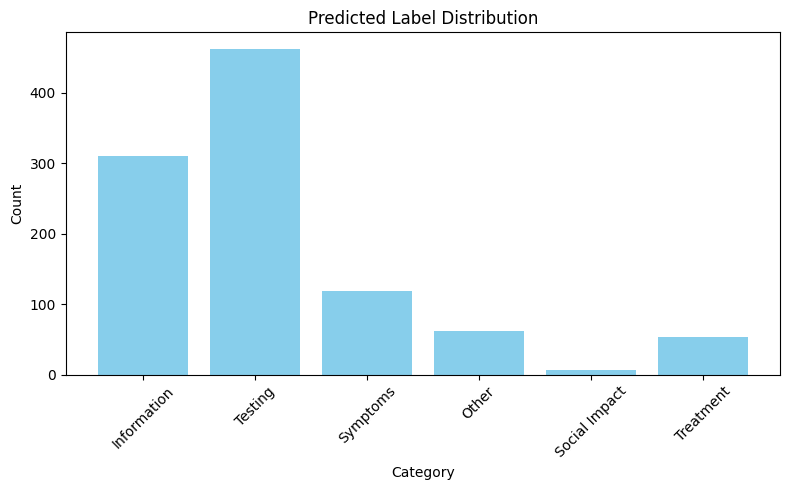

In [ ]:
classifier = pipeline("zero-shot-classification", model="roberta-large-mnli", device=0)

# Run Predictions
results = classifier(texts, candidate_labels, batch_size=8)
predicted_labels = [r["labels"][0] for r in results]

# 🔄 Run Predictions
results = classifier(texts, candidate_labels, batch_size=8)
predicted_labels = [r["labels"][0] for r in results]

# ✅ Evaluate Accuracy
correct = sum(p == t for p, t in zip(predicted_labels, true_labels))
total = len(true_labels)
accuracy = correct / total
print(f"✅ Model Accuracy on {total} examples: {correct}/{total} = {accuracy:.2%}")

# 🔍 Show Sample Misclassifications
print("\n🔍 Misclassified Examples:")
for i, (text, pred, true) in enumerate(zip(texts, predicted_labels, true_labels)):
    if pred != true and i < 10:
        print(f"\n{i+1}. 📩 Text: {text}")
        print(f"   ❌ Predicted: {pred}")
        print(f"   ✅ True:      {true}")

# 📊 Visualize Label Distribution
from collections import Counter
import matplotlib.pyplot as plt

label_counts = Counter(predicted_labels)
labels = list(label_counts.keys())
counts = list(label_counts.values())

plt.figure(figsize=(8, 5))
plt.bar(labels, counts, color='skyblue')
plt.title("Predicted Label Distribution")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
top_k = 3
correct_top_k = 0

for true, output in zip(true_labels, results):
    top_k_preds = output["labels"][:top_k]
    if true in top_k_preds:
        correct_top_k += 1

top_k_accuracy = correct_top_k / len(true_labels)
print(f"🎯 Top-{top_k} Accuracy: {correct_top_k}/{len(true_labels)} = {top_k_accuracy:.2%}")

🎯 Top-3 Accuracy: 538/1013 = 53.11%


### 🎯 Top-3 Accuracy Evaluation

Since zero-shot classification can struggle with abstract labels or closely related categories, we computed **Top-3 accuracy** to see whether the correct label appears among the model's top 3 predictions.

- **Model**: `roberta-large-mnli`
- **Top-1 Accuracy**: 27.74%
- **Top-3 Accuracy**: 53.11%
- This suggests the model often ranks the correct label **second or third**, even when it's not the top prediction.

Misclassifications of abstract or speculative questions like “will covid go away?” may still include the correct category in the top 3, even if not ranked first.

## Project Summary

This project explores the use of large language models (LLMs) for classifying de-identified, COVID-related health questions using zero-shot learning.

We used the `facebook/bart-large-mnli` and `roberta-large-mnli` models from Hugging Face's Transformers library to predict one of six broad health-related categories:

- Symptoms
- Testing
- Treatment
- Social Impact
- Information
- Other

The original COVID-Q dataset included fine-grained labels (e.g., “Symptoms - Fever”, “Testing - PCR”), which we mapped to these broader categories for improved model interpretability and evaluation.

---

### 🔍 Model Performance (RoBERTa)

- **Dataset size**: 1,013 examples
- **Top-1 Accuracy**: 27.74%
- **Top-3 Accuracy**: 53.11%

While overall top-1 accuracy was modest, the model correctly included the ground-truth label in its top 3 predictions more than half the time — a promising result for zero-shot text triage without any domain-specific fine-tuning.

---

### ⚠️ Observations

- The model frequently misclassified abstract or speculative questions (e.g., “Will COVID go away?”) as "Symptoms" or "Testing" instead of "Information"
- This suggests that zero-shot models rely heavily on surface-level cues, and may benefit from prompt tuning or domain-specific label phrasing

---

### 💡 Next Steps

- Experiment with prompt rewording (e.g., “abstract question”, “future concern”)
- Try other models (e.g., `flan-t5-xl`, `deberta-v3-mnli`)
- Fine-tune with a small labeled subset to improve handling of edge cases

